# Project proposal: Stock-price prediction

Stock market prediction has attracted much attention from academia as well as business. Due
to the non-linear, volatile and complex nature of the market, it is quite difficult to predict. As
the stock markets grow bigger, more investors pay attention to develop a systematic approach
to predict the stock market. Since the stock market is very sensitive to the external information,
the performance of previous prediction systems is limited by merely considering the traditional
stock data. New forms of collective intelligence have emerged with the rise of the Internet (e.g.
Google Trends, Wikipedia, etc.). The changes on these platforms will significantly affect the
stock market. In addition, both the financial news sentiment and volumes are believed to have
impact on the stock price.

In this project, you should develop and evaluate a prediction model that could be used to predict
the stocks’ short-term movement, and price. Besides historical data directly from the stock
market, some external data sources should also be considered as inputs to the model.

In summary, the contributions to this work are listed below:

1. Detect the potential factors(features) that could impact the stock market and acquire the
data from disparate data sources: 
    
    (a) publicly available market information on stocks such as Yahoo Finance, including opening/closing prices, trade volume, etc.; 

    (b) commonly used technical indicatorsfrom Yahoo finance that reflect price variation over time such as Stochastic Oscillator (%K), the Larry William (LW) % R Indicator and the Relative Strength Index (RSI) ; 

    (c) daily counts of Google Trends on the stocks of interest; 
     
    (d) the number of unique visitors for pertinent Wikipedia pages per day.

2. Use a variable selection method such as PCA, Correlation Coefficient or any other suitable methods to filter the most important features.

3. Make use of Artificial Neural Networks and most important featuresfrom disparate data sources to build the forecasting model.

4. The proposed model should allow investors to predict the next-day Closing, Opening or both prices for a particular stock or index.

5. Evaluate the prediction model based on different metrics(ex. MSE, MAPE) and provide decision making suggestions for the investors.

Note 1: You can use any stock such as AAPL for Apple, GOOG for Google, and etc.

Note 2. Use the best practices you learned in the course to solve the problem.
To obtain more information about this project, you can refer to the Chapter 2 of the
following paper: Application of machine learning techniques for stock market
prediction, Bin Weng, 2017.


# Factors 
Hvilke variabler må være med i modellen?

1. price on market open and close, trade volume, etc
2. technical indicators: Stochastic, Willams %R, Relative Strength Index ...
simple moving average?
3. daily count of Google Trends on the stock of interest
4. the number of unique visitors for pertinent Wikipedia pages per day 




# Drøfting

Implementeringen, bør til slutt være så enkel at en kan velge et selskap som input og få ut en prisprediksjon.

Gjøre implementeringen i "klasser"? 

Får først koden til å fungere for apple, sørg for at hele prosessen eg: Identifisere beste features, lager en eller flere machine lerarning modeller som så gjennomfører selve analysen. Implementer det så i generell form.


---------Hvilken ANN modell? -> Prøver først med MLP (multi layered perceptron)
        Kan også prøve: 
        Support Vector Machines (SVM) 
        LSTM (Long short term memory) 

Data må normaliseres før det blir til input???

In [5]:
# import guide https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb

#!pip install yfinance
#!pip install pytrends --upgrade
#!pip install --upgrade --user git+https://github.com/GeneralMills/pytrends
#!pip install git+https://github.com/Commonists/pageview-api.git

  Cloning https://github.com/Commonists/pageview-api.git to c:\users\lars\appdata\local\temp\pip-req-build-orral7e0
  Created wheel for pageviewapi: filename=pageviewapi-Undefined-py3-none-any.whl size=5345 sha256=90cdca961dda9943de45a05032c2685aae7b333eb686dd3f8ad90478dada4d9e
  Stored in directory: C:\Users\Lars\AppData\Local\Temp\pip-ephem-wheel-cache-lmiu0oyg\wheels\e8\3a\ac\a1a47ff2f5621ea13ecac16035f07c2c35ee2509404d828171
Successfully built pageviewapi


# Libraries
Yahoo finance - yfinance: get stock data..


In [106]:
import yfinance as yf # eller bare pandas datareader?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
from pytrends.request import TrendReq
import pageviewapi as wik
pytrend = TrendReq()

#imports from sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split



Enter desired ticker

In [21]:
# Yahoo finance - get data
TICKER = 'AAPL'

stock = yf.Ticker(TICKER)
#stock.info

print(stock.info['shortName'])

Apple Inc.


In [36]:
stock.history(interval='1d', start='2000-1-1', end = '2002-1-1')
stock_open_price = stock.history(interval='1d', start='2000-1-1', end = '2002-1-1')['Open']

stock_open_and_close = stock.history(interval = '1d',  start = '2000-1-1', end = '2002-1-1')[['Open','Close']]

print(stock_open_and_close)


                Open     Close
Date                          
1999-12-31  0.771131  0.785456
2000-01-03  0.801213  0.855168
2000-01-04  0.826997  0.783068
2000-01-05  0.792618  0.794528
2000-01-06  0.810762  0.725771
...              ...       ...
2001-12-24  0.319339  0.326368
2001-12-26  0.326215  0.328354
2001-12-27  0.329729  0.337216
2001-12-28  0.335688  0.342716
2001-12-31  0.343939  0.334618

[501 rows x 2 columns]


,Apple Inc.,AAPL,Apple,isPartial
date,,,,
2018-01-01 00:00:00,0,0,81,False
2018-01-01 01:00:00,0,0,81,False
2018-01-01 02:00:00,0,0,80,False
2018-01-01 03:00:00,0,0,78,False
2018-01-01 04:00:00,0,0,73,False
...,...,...,...,...
2018-01-31 20:00:00,0,2,78,False
2018-01-31 21:00:00,0,3,81,False
2018-01-31 22:00:00,0,3,84,False


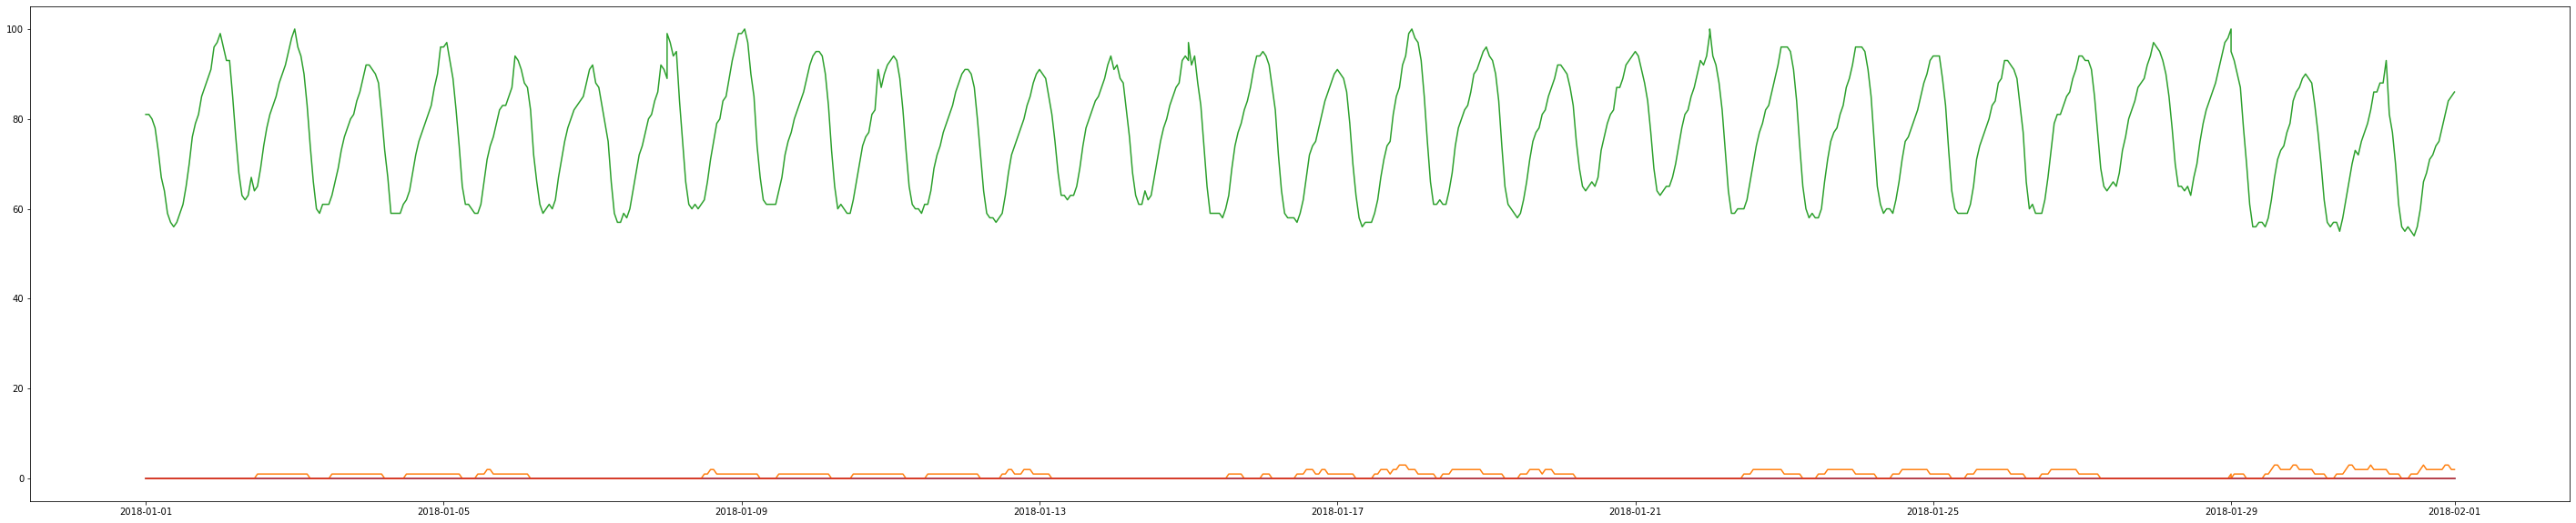

In [31]:
# Google trends data



def get_company_name(comp_name):
    if len(comp_name) > 2:
        return comp_name[0:1]
    else:
        return comp_name[0]



keyword_list = [stock.info['shortName'], stock.info['symbol'], get_company_name(stock.info['shortName'].split(' '))]

#pytrend.build_payload(kw_list=[keyword_list])

trend = pytrend.get_historical_interest(keyword_list, year_start=2018, month_start=1, day_start=1, hour_start=0, year_end=2018, month_end=2, day_end=1, hour_end=0, cat=0, geo='', gprop='', sleep=0)
plt.figure(figsize=(50,10))
plt.plot(trend)
trend

In [149]:
###### WIKIPEDIA pageviews

whack1 = wik.per_article('en.wikipedia', 'Apple_Inc.', '20191106', '20201120',
                        access='all-access', agent='all-agents', granularity='daily')
df_whack = pd.DataFrame(whack1['items'])
df_whack['timestamp'] = pd.to_datetime(df_whack['timestamp'], format = '%Y%m%d%H')
df_whack.set_index('timestamp', inplace = True)
print(df_whack)




                 project     article granularity      access       agent  \
timestamp                                                                  
2019-11-06  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   
2019-11-07  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   
2019-11-08  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   
2019-11-09  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   
2019-11-10  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   
...                  ...         ...         ...         ...         ...   
2020-11-16  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   
2020-11-17  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   
2020-11-18  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   
2020-11-19  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   
2020-11-20  en.wikipedia  Apple_Inc.       daily  all-access  all-agents   

           

Stochastic oscillator: 

\begin{equation}
\tag{1}
\% \mathrm{K}  = \frac{C -L14}{H14 -L14}
\end{equation}

Where $C =$ most recent closing price, $H14 =$ highest traded price for last 14 day period, and $L14 =$ lowest traded price for last 14 day period.   




Larry Williams %R indicator:

The Formula for the Williams %R Is:
\begin{aligned} &\text{Wiliams \%}R=\frac{\text{Highest High}-\text{Close}}{\text{Highest High}-\text{Lowest Low}}\\ &\textbf{where}\\ &\text{Highest High} = \text{Highest price in the lookback}\\ &\text{period, typically 14 days.}\\ &\text{Close} = \text{Most recent closing price.}\\ &\text{Lowest Low} = \text{Lowest price in the lookback}\\ &\text{period, typically 14 days.} \end{aligned} 
​	  
Wiliams %R= 
Highest High−Lowest Low
Highest High−Close
​	 
where
Highest High=Highest price in the lookback
period, typically 14 days.
Close=Most recent closing price.
Lowest Low=Lowest price in the lookback
period, typically 14 days.

### note that Stoch_osc = -LW_R_indicator  ???? Need not use both then


In [2]:
def datagetter(TICKER,  interval = '1d', start = '2017-01-01', end = '2020-10-20'):
    """Function that takes ticker, and name of firm as input and retrieves relevant data as pandas dataframe"""
    tick = yf.Ticker(TICKER)
    Name =tick.info['shortName']

    ### Section where data is from yahoo
    out_df= tick.history(interval = interval,  start=start, end=end)[['Open','Close']]
    
    ##Williams %R indicator
    williams = out_df['Close'].rolling(14).apply(lambda x: (x.max() -x[-1])/(x.max()- x.min()))
    out_df['williams_R'] = williams
    
    ### wikipedia data
    wikistart = start.replace('-','')
    wikiend = end.replace('-','')
    try:
        wikidata = wik.per_article('en.wikipedia', Name, wikistart, wikiend,access='all-access', agent='all-agents', granularity='daily')
        df_wiki = pd.DataFrame(wikidata['items'])
        df_wiki['timestamp'] = pd.to_datetime(df_wiki['timestamp'], format = '%Y%m%d%H')
        df_wiki.set_index('timestamp', inplace = True)
        out_df['wikiviews'] = df_wiki['views']
    except:
        print('fungerte ikke')
    
    ### Google trends

    return out_df.dropna() #drops nan values, at least 14 drops because of williams R is computed by 14day rolling window, nan for first days

apple_data = datagetter('AAPL')

print(apple_data)




                  Open       Close  williams_R  wikiviews
Date                                                     
2017-01-23   28.181802   28.200590    0.000000      13894
2017-01-24   28.076121   28.174757    0.027093      14157
2017-01-25   28.280436   28.623314    0.000000      13459
2017-01-26   28.573997   28.637407    0.000000      13543
2017-01-27   28.684377   28.639755    0.000000      11873
...                ...         ...         ...        ...
2020-10-13  125.054250  120.891434    0.203956      29580
2020-10-14  120.791602  120.981277    0.264852      28546
2020-10-15  118.515535  120.502106    0.324253      21728
2020-10-16  121.071120  118.815010    0.472760      21000
2020-10-19  119.753392  115.780251    0.739895      17900

[943 rows x 4 columns]


# Variable selection methods

## Correlation Matrix
Easily found with pandas, the correlation matrix expresses the correlations between the data. If we were to analyse the correlation between the datapoint with different lags in time, then we can use this as aid to select the most important features.

## Principal component analysis:
Common method to reduce dimensinality of prediction/training data for predictive models. 
PCA can be broken down into the following steps: 

1) Standarization
(Z-score)

2) Compute Covariance Matrix

3) Compute Eigen-vectors of covariance matrix.
The eigen vectors can be interpeted as the principal components e.g the combinations of features which maximise variance, and the eigen value corresponds to the amount of total variance carried in each principal component. Hence we can rank the principal components in the order of highest eigenvalue

4) Find feature vectors.
The feature vectors is a matrix conisting of the eigen vectors of the components we decide to keep in decending order. 

5) Obtain the new "better suited" data:
The new data is obtained by matrix multtiplication
\begin{equation}
NewData = featureVector^{T} \cdot NormalizedOldData^{T}
\end{equation}

In [3]:
#correlation matrix
corrs = apple_data.corr()
print(corrs) 


                Open     Close  williams_R  wikiviews
Open        1.000000  0.998940   -0.116958   0.322372
Close       0.998940  1.000000   -0.128974   0.321308
williams_R -0.116958 -0.128974    1.000000  -0.016409
wikiviews   0.322372  0.321308   -0.016409   1.000000


[[-1.39885154 -0.93183923  0.92550337]
 [-1.38569535 -0.83508391  0.97607632]
 [-1.42903339 -0.97088986  0.80381204]
 ...
 [ 4.83285522  0.81682113  0.48982013]
 [ 4.7236311   1.15321706  0.17223824]
 [ 4.15894512  1.58906444 -0.79975826]]


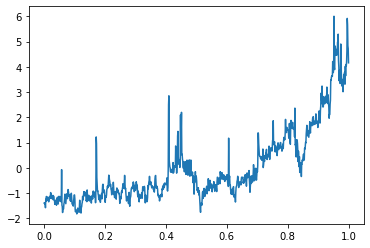

In [119]:
### Principal component analysis

# test_data = normalize(apple_data) #Normalizer scales row-wise, Not sure if neccessary

scaler_for_pca = StandardScaler() #StandardScaler scales columnwise
scaler_for_pca.fit(apple_data)
pca_test_data = scaler_for_pca.transform(apple_data) 

pca = PCA(n_components='mle', svd_solver='full')
pca.fit(pca_test_data)
dimension_reduced_data = pca.transform(pca_test_data)
print(dimension_reduced_data)

fig2, axz = plt.subplots()
axz.plot(np.linspace(0,1, num =943),dimension_reduced_data[:,0])

## RFE, Recursive Feature elimination
 Another approach to feature selection

### MLP Regressor

Class MLPClassifier and MPLRegressor implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation.

MLP trains on two arrays: array X of size (n_samples, n_features), which holds the training samples represented as floating point feature vectors; and array y of size (n_samples,), which holds the target values (class labels) for the training samples:

In [154]:
### Testing MLP

### First without Scaling/standardizing data
raw_training =apple_data.copy()
y_tr = raw_training['Open'].shift(-1) 
raw_y = np.array(y_tr.dropna())
raw_X = np.array(training_data[:-1]) #dropping last value since since target data contains one less row 

raw_last_day_data = np.array(training_data.iloc[-1]).reshape(1,-1)

raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(raw_X, raw_y,random_state=1, test_size =0.2)
raw_regr = MLPRegressor(random_state=1, max_iter=500).fit(raw_X_train, raw_y_train)

raw_prediction =raw_regr.predict(raw_X_test)

#With scaled/standardized values, 
y_scaler = StandardScaler()
y_scaler.fit(raw_y.reshape(-1,1))
scaled_y = y_scaler.transform(raw_y.reshape(-1,1))
scaled_X = np.array(pca_test_data[:-1])           #using the previously scaled data, this should be cleaned to be a little neater

scaled_last_day_data = pca_test_data[-1]

scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = train_test_split(scaled_X, scaled_y,random_state=1, test_size =0.2)
scaled_regr = MLPRegressor(random_state =1, max_iter=500).fit(scaled_X_train,scaled_y_train)

scaled_prediction = scaled_regr.predict(scaled_X_test)



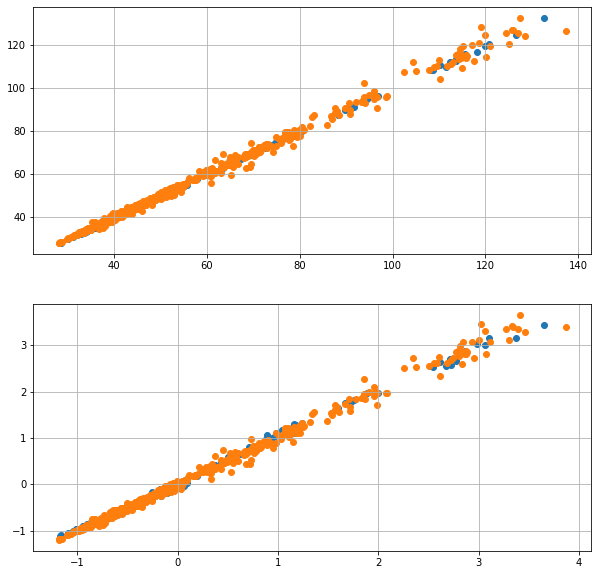

In [162]:
### Plotting Tests

testfig, axes = plt.subplots(2, figsize = (10,10))
axes[0].scatter(raw_X_test[:,0], raw_prediction, label = 'Scaled ')
axes[0].scatter(raw_X_train[:,0],raw_y_train)
axes[1].scatter(scaled_X_test[:,0], scaled_prediction)
axes[1].scatter(scaled_X_train[:,0], scaled_y_train)
axes[0].grid()
axes[1].grid()